# Visualizing Loci
Uses GeneticsMakie.jl to produce LocusZoom style plots

### SCZ

In [1]:
# # Installing packages
# using Pkg
# Pkg.add(["CairoMakie", "Colors", "CSV", "DataFrames", "GeneticsMakie", "SnpArrays"])
using Pkg; Pkg.activate(joinpath(homedir(), "project-gandalm/julia_envs/main_julia"))

  Activating new environment at `~/project-gandalm/julia_envs/main_julia/Project.toml`


In [2]:
using CairoMakie, Colors, CSV, DataFrames, GeneticsMakie, SnpArrays, Statistics

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
[ Info: Precompiling GeneticsMakie [8ca62643-82d8-47b5-a233-a06d1654fb35]


# Loading in custom functions

In [9]:
# LDMatrix
mutable struct LDMatrix
    snp_info::AbstractDataFrame
    ld::AbstractMatrix
end

function read_LDMatrix(prefix)
    snp_info = CSV.read(prefix * ".bim", DataFrame;
                        header = ["chromosome", "snpid", "genetic_distance", 
                                  "position", "allele1", "allele2"],
                        types = [String, String, Float64, Int64, String, String])
    ld =
    CSV.File(prefix * ".ld.gz";
             delim = " ", types = Float64, header = 0) |>
    Tables.matrix
    if all(ismissing.(ld[:, end])) && size(ld, 1) + 1 == size(ld, 2)
        ld = ld[:, 1:(end - 1)]
    end
    LDMatrix(snp_info, ld)
end

# plotlocus! code
function setticks(y::Real)
    if y == 10
        return 0:3:10
    elseif 10 < y <= 20
        return 0:5:y
    elseif 20 < y <= 50
        return 0:10:y
    else
        s = div(y, 4)
        d, r = divrem(s, 10)
        return r < 5 ? (0:10d:y) : (0:((d + 1) * 10):y)
    end
end

function calculateld!(
    gwas::DataFrame, 
    ref::SnpData; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas, ref; matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
        for j in 1:n
            gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ref)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            geno = convert(Matrix{Float64}, ref.snparray[:, [i; gwas.ind]])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, 1], geno[:, j + 1])^2    
            end
        else
            snp = gwas.SNP[i]
            geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

function calculateld!(
    gwas::DataFrame, 
    ldmat::LDMatrix; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas,
                                      select(ldmat.snp_info, :chromosome => :CHR, :position => :BP);
                                      matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        matchedld = ldmat.ld[gwas.ind, gwas.ind]
        for j in 1:n
            gwas.LD[j] = matchedld[i, j]
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ldmat.snp_info.snpid,
                                                 ldmat.snp_info.chromosome,
                                                 ldmat.snp_info.position)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        else
            snp = gwas.SNP[i]
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

"""
    plotlocus!(ax::Axis, chromosome::AbstractString, range1::Real, range2::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, gene::AbstractString, gwas::DataFrame, gencode::DataFrame; kwargs)

Plot `gwas` results within a given `chromosome` and genomic range between `range1` 
and `range2`.

Alternatively, plot within a given `chromosome` and a certain `window` around a 
genomic coordinate `bp` or plot within a certain `window` around `gene`.

# Arguments
- `ld::Union{Nothing, SnpData, AbstractMatrix, Tuple{Union{SnpData, AbstractMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing`: 
    the reference panel for which LD is calculated.
- `ymax::Real`: the maximum value for y axis. 
- `window::Real = 1e6`: the window around `bp` or `gene`. 
"""
function plotlocus!(
    ax::Axis,
    chromosome::AbstractString,
    range1::Real,
    range2::Real,
    gwas::DataFrame;
    ld::Union{Nothing, SnpData, LDMatrix, Tuple{Union{SnpData, LDMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing,
    ymax::Real = 0
    )

    locuszoomcolormap = [colorant"#377fbd",
                         colorant"#45b9da",
                         colorant"#5baf68",
                         colorant"#faa600",
                         colorant"#d43f38"]
    function tofifth(x)
        if ismissing(x) || isnothing(x) || isnan(x)
            return NaN
        elseif x <= 0
            return 1
        elseif x >= 1
            return 5
        else
            return Int64(ceil(x * 5))
        end
    end
    df = filter(x -> (x.CHR == chromosome) && (x.BP >= range1) && (x.BP <= range2), gwas)
    if nrow(df) == 0
        ymax == 0 ? ymax = 10 : nothing
        ax.spinewidth = 0.75
        ax.ytickwidth = 0.75
        ax.ylabelsize = 6
        ax.yticklabelsize = 6
        ax.yticksize = 3
        ax.yticks = setticks(ymax)
        xlims!(ax, range1, range2)
        ylims!(ax, 0, ymax)
        hidespines!(ax, :t, :r)
        hidexdecorations!(ax)
        hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
        return
    end
    df.P = -log.(10, df.P)
    if ymax == 0
        ymax = maximum(df.P) / 4 * 5
        ymax <= 10 ? ymax = 10 : nothing
    end
    if !isnothing(ld)
        typeof(ld) <: Union{SnpData, LDMatrix} ? calculateld!(df, ld) : calculateld!(df, ld[1]; snp = ld[2])
        scatter!(ax, df.BP, df.P, color = tofifth.(df.LD),
            colormap = locuszoomcolormap, markersize = 1.5 * 1.5)
        if typeof(ld) == SnpData
            ind = argmax(df.P)
            bp = df.BP[ind]
            p = df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), fontsize = 6, align = (:center, :bottom))    
        elseif length(df.index[1]) > 0
            ind = findfirst(df.SNP .== df.index[1])
            bp, p = df.BP[ind], df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), fontsize = 6, align = (:center, :bottom))    
        end
    else
        scatter!(ax, df.BP, df.P, color = :gray60, markersize = 1.5 * 1.5)
    end
    ax.spinewidth = 0.75
    ax.ytickwidth = 0.75
    ax.ylabelsize = 6
    ax.yticklabelsize = 6
    ax.yticksize = 3
    ax.yticks = setticks(ymax)
    xlims!(ax, range1, range2)
    ylims!(ax, 0, ymax)
    hidespines!(ax, :t, :r)
    hidexdecorations!(ax)
    hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
end

plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; window::Real = 1e6, kwargs...) =
    plotlocus!(ax, chromosome, bp - window, bp + window, gwas; kwargs...)

plotlocus! (generic function with 2 methods)

# Loading in data

The `plotlocus!` function takes in either 1) binary plink files or 2) .bim + .ld.gz file pair to color the SNPs by LD. In the next code block, set the `plinkbfiles` variable to true or false.

In [4]:
plinkbfiles = true

true

In [5]:
gencodefilename = "/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33/gencode.v33lift37.annotation.gtf"
sumstatsfilename = "/u/project/gandalm/shared/GWAS/SCZ.PGC3.2021/wave3_v3/PGC3_SCZ_wave3.european.autosome.public.v3.tsv"
ldfolder = "/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink"

function loaddata(gencodefilename::AbstractString, sumstatsfilename::AbstractString)
    gencode = CSV.read(gencodefilename, DataFrame; delim = '\t', comment = "#", 
                                        header = ["seqnames", "source", "feature", 
                                                  "start", "end", "score", "strand", 
                                                  "phase", "info"])
    GeneticsMakie.parsegtf!(gencode)
    sumstats = CSV.read(sumstatsfilename, DataFrame)
    GeneticsMakie.mungesumstats!(sumstats)
    return (gencode, sumstats)
end

gencode, sumstats = loaddata(gencodefilename, sumstatsfilename)

(2915984×14 DataFrame
     Row │ seqnames  source   feature      start  end    score    strand   pha ⋯
         │ String    String7  String15     Int64  Int64  String1  String1  Str ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 1         HAVANA   gene         11869  14409  .        +        .   ⋯
       2 │ 1         HAVANA   transcript   11869  14409  .        +        .
       3 │ 1         HAVANA   exon         11869  12227  .        +        .
       4 │ 1         HAVANA   exon         12613  12721  .        +        .
       5 │ 1         HAVANA   exon         13221  14409  .        +        .   ⋯
       6 │ 1         HAVANA   transcript   12010  13670  .        +        .
       7 │ 1         HAVANA   exon         12010  12057  .        +        .
       8 │ 1         HAVANA   exon         12179  12227  .        +        .
       9 │ 1         HAVANA   exon         12613  12697  .        +        .   ⋯
      10 │ 1         HAVANA   

In [6]:
# show protein-coding genes only
gencode = filter(row -> row.gene_type == "protein_coding", gencode)

Row,seqnames,source,feature,start,end,score,strand,phase,info,gene_id,gene_name,gene_type,transcript_id,transcript_support_level
,String,String7,String15,Int64,Int64,String1,String1,String1,String,SubStrin…,SubStrin…,SubStrin…,SubStrin…,Any
1,1,HAVANA,gene,65419,71585,.,+,.,"gene_id ""ENSG00000186092.6_4""; gene_type ""protein_coding""; gene_name ""OR4F5""; level 2; hgnc_id ""HGNC:14825""; havana_gene ""OTTHUMG00000001094.4_4""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000186092,OR4F5,protein_coding,ENSG00000186092,missing
2,1,HAVANA,transcript,65419,71585,.,+,.,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""; havana_gene ""OTTHUMG00000001094.4_4""; havana_transcript ""OTTHUMT00000003223.4_2""; remap_num_mappings 1; remap_status ""full_contig""; remap_target_status ""new"";",ENSG00000186092,OR4F5,protein_coding,ENST00000641515,missing
3,1,HAVANA,exon,65419,65433,.,+,.,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; exon_number 1; exon_id ""ENSE00003812156.1_1""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""; havana_gene ""OTTHUMG00000001094.4_4""; havana_transcript ""OTTHUMT00000003223.4_2""; remap_original_location ""chr1:+:65419-65433""; remap_status ""full_contig"";",ENSG00000186092,OR4F5,protein_coding,ENST00000641515,missing
4,1,HAVANA,UTR,65419,65433,.,+,.,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; exon_number 1; exon_id ""ENSE00003812156.1""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""; havana_gene ""OTTHUMG00000001094.4_4""; havana_transcript ""OTTHUMT00000003223.4_2""; remap_original_location ""chr1:+:65419-65433""; remap_status ""full_contig"";",ENSG00000186092,OR4F5,protein_coding,ENST00000641515,missing
5,1,HAVANA,exon,65520,65573,.,+,.,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; exon_number 2; exon_id ""ENSE00003813641.1_1""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""; havana_gene ""OTTHUMG00000001094.4_4""; havana_transcript ""OTTHUMT00000003223.4_2""; remap_original_location ""chr1:+:65520-65573""; remap_status ""full_contig"";",ENSG00000186092,OR4F5,protein_coding,ENST00000641515,missing
6,1,HAVANA,UTR,65520,65564,.,+,.,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; exon_number 2; exon_id ""ENSE00003813641.1""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""; havana_gene ""OTTHUMG00000001094.4_4""; havana_transcript ""OTTHUMT00000003223.4_2""; remap_original_location ""chr1:+:65520-65564""; remap_status ""full_contig"";",ENSG00000186092,OR4F5,protein_coding,ENST00000641515,missing
7,1,HAVANA,CDS,65565,65573,.,+,0,"gene_id ""ENSG00000186092.6_4""; transcript_id ""ENST00000641515.2_2""; gene_type ""protein_coding""; gene_name ""OR4F5""; transcript_type ""protein_coding""; transcript_name ""OR4F5-202""; exon_number 2; exon_id ""ENSE00003813641.1""; level 2; protein_id ""ENSP00000493376.2""; hgnc_id ""HGNC:14825""; tag ""RNA_Seq_supported_partial""; tag ""basic""

**Change colormap**

In [10]:
# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
function coloc_1e5(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real},
               coloctitles::Array{<:AbstractString},
               ldfilename::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    locuszoomcolormap = [colorant"#377fbd",
                         colorant"#45b9da",
                         colorant"#5baf68",
                         colorant"#faa600",
                         colorant"#d43f38"]
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    colocfiles = DataFrame[colocfiles...]
    GeneticsMakie.mungesumstats!(colocfiles)
    chr, start, stop = GeneticsMakie.findgene(gene, gencode)
    range1 = start - 1e5
    range2 = stop + 1e5
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    ldfilename = tempname()
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = ldfilename)
    ld = SnpData(ldfilename)
    f = Figure(resolution = (306, 792))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = coloctitles[i]
        if isnothing(snp)
            plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 30)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    ldfilename = tempname()
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = ldfilename)
    ld = SnpData(ldfilename)
    if isnothing(snp)
        plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "SCZ GWAS", fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 30)
    # Visualize genes
    rs = GeneticsMakie.plotgenes!(axs[n + 2], chr, range1, range2, gencode, height = 0.1)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
    GeneticsMakie.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    return f
end

coloc_1e5 (generic function with 1 method)

In [11]:
# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
function coloc_5e5(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real},
               coloctitles::Array{<:AbstractString},
               ldfilename::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    locuszoomcolormap = [colorant"#377fbd",
                         colorant"#45b9da",
                         colorant"#5baf68",
                         colorant"#faa600",
                         colorant"#d43f38"]
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    colocfiles = DataFrame[colocfiles...]
    GeneticsMakie.mungesumstats!(colocfiles)
    chr, start, stop = GeneticsMakie.findgene(gene, gencode)
    range1 = start - 5e5
    range2 = stop + 5e5
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    ldfilename = tempname()
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = ldfilename)
    ld = SnpData(ldfilename)
    f = Figure(resolution = (306, 792))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = coloctitles[i]
        if isnothing(snp)
            plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 30)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    ldfilename = tempname()
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = ldfilename)
    ld = SnpData(ldfilename)
    if isnothing(snp)
        plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "SCZ GWAS", fontsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 30)
    # Visualize genes
    rs = GeneticsMakie.plotgenes!(axs[n + 2], chr, range1, range2, gencode, height = 0.1)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
    GeneticsMakie.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", fontsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    return f
end

coloc_5e5 (generic function with 1 method)

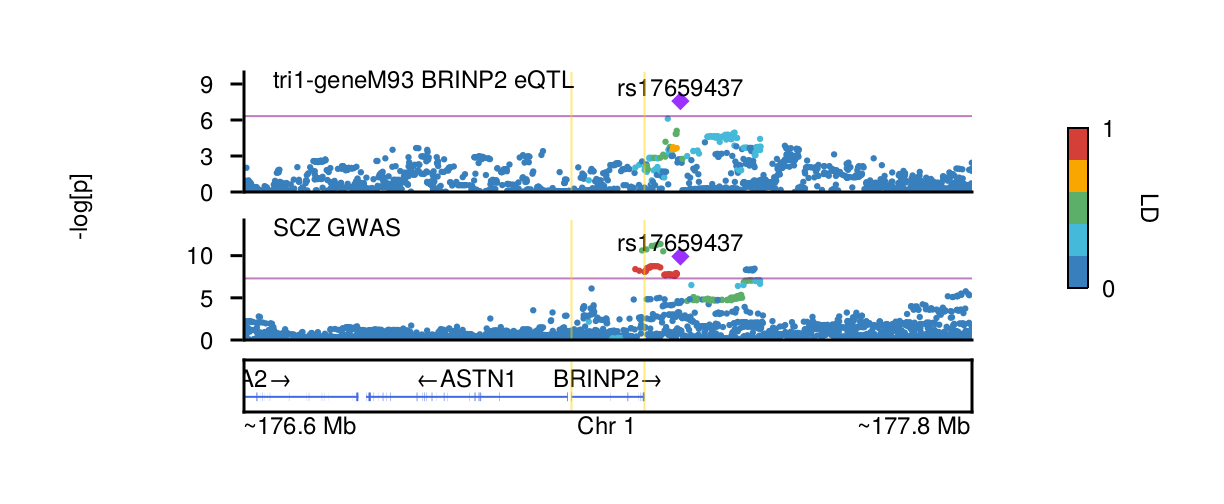

In [15]:
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = coloc_5e5("BRINP2",
      ["/u/project/gandalm/cindywen/isoform_twas/colocal/locuszoom/BRINP2/tri1-genemod-greenyellow-BRINP2_fdr.txt"],
      [6.325064],
      ["tri1-geneM93 BRINP2 eQTL"],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test";
      snp = "rs17659437")

In [16]:
CairoMakie.activate!(type = "png")
outputfilename = "../locuszoom/BRINP2/BRINP2_v2.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


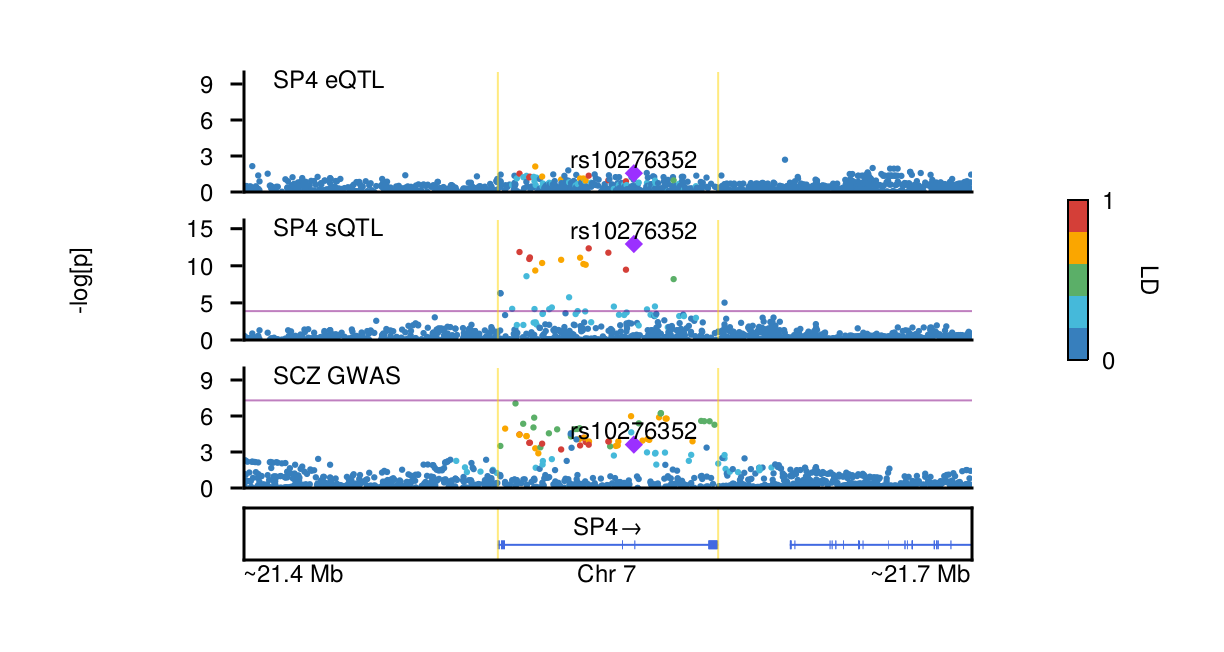

In [12]:
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = coloc_1e5("SP4",
      ["/u/project/gandalm/cindywen/isoform_twas/colocal/locuszoom/SP4/ENSG00000105866.txt", "/u/project/gandalm/cindywen/isoform_twas/colocal/locuszoom/SP4/7:21516925:21521542:clu_100938_NA.txt"],
      [0, 3.892946],
      ["SP4 eQTL", "SP4 sQTL"],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test";
      snp = "rs10276352")

In [14]:
CairoMakie.activate!(type = "png")
outputfilename = "../locuszoom/SP4/SP4.png"
save(outputfilename, f, px_per_unit = 4)

CairoMakie.Screen{IMAGE}


# Save file

Set filename in cell below

In [ ]:
CairoMakie.activate!(type = "png")
outputfilename = ""
# save(filename, f, px_per_unit = 4)